In [1]:
from numba import float32,int32,int8,jit,cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32,xoroshiro128p_uniform_float64
from numba.cuda.random import xoroshiro128p_normal_float32
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import math
from util import *
import torch
from torch import nn

# Using the decompression functions from data generation

In [2]:
@cuda.jit
def decompress2D(inn,states):
    """Inverse function of compress
    Note: This is slightly changed to work with the correct tensor shape"""
    sz,_,sx,sy=states.shape
    #n is which 2d grid ur on, i is which set of 8 numbers you're on
    n,i=cuda.grid(2)
    #get the 2d grid
    state=states[n][0]
    num = inn[n][i]
    for bit in range(8):
        idx=i*8+bit
        x = idx//sy
        y = idx%sy
        #make it a snake pattern. . .
        if x%2==1:
            y=sy-y-1
        state[x][y]=1&(num>>bit)

@cuda.jit
def decompress1D(inn,states):
    """Similar to decompress 2D but instead of being an inverse to compress it squishes the 2D
    array output into a 1D array (which is now in a snake pattern)
    if states has shape [N,X,1] then out should have shape [M,Z/8]
    and the blocks/threads should have shape [N,Z/8]
    Here Z=X*Y where each state has shape [X,Y] on a 2D grid
    
    Note: This is slightly changed to work with the correct tensor shape
    """
    #n is which grid ur on, i is which set of 8 numbers you're on
    n,i=cuda.grid(2)
    #get the grid
    state=states[n]
    num = inn[n][i]
    for bit in range(8):
        idx=i*8+bit
        #get each value in 1d
        state[idx][0]=1&(num>>bit)

In [3]:
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [4]:
bsize=1024
N=32

#bsize=2048
#N=16

#bsize=4096
#N=8

B=0.4407

modeltype='2d'

# Implementing a simple RNN model

In [5]:
class RNN(nn.Module):
    def __init__(self,device=device, **kwargs):
        super(RNN, self).__init__()
        
        self.rnn = nn.RNN(input_size=1,hidden_size=128,batch_first=True)
        self.lin = nn.Sequential(
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,1),
                nn.Sigmoid()
            )
        self.device=device
        self.to(device)
    def forward(self, input):
        # h0 has shape [N,L,H]
        h0=torch.zeros([1,input.shape[0],128]).to(device)
        out,h=self.rnn(input,h0)
        return self.lin(out)

# Making a blocked CNN

This doesn't learn anything right now

In [6]:
class BlockedCNN(nn.Module):
    def __init__(self,device,N):
        super(BlockedCNN, self).__init__()
        self.N=N
        tmp=np.arange(N**2).reshape([N,N])
        tmp[1::2,:]=tmp[1::2,::-1]
        plt.imshow(tmp)
        plt.show()
        tmp2 = np.array([[tmp<=i for i in range(N**2-1)]])

        self.mul=torch.tensor(tmp2).to(device).unsqueeze(2)
        self.add=torch.tensor(tmp2-1).to(device).unsqueeze(2)
        
        print(self.add.shape)
        
        self.net = nn.Sequential(
                nn.Conv2d(1,8,N//4,padding='same',padding_mode ='circular'),
                nn.ReLU(True),
                nn.MaxPool2d(2),
                nn.Conv2d(8,16,N//4,padding='same',padding_mode ='circular'),
                nn.ReLU(True),
                nn.MaxPool2d(2),
                nn.Flatten(),
                #Insize is 256, outsize is 10
                nn.Linear(N**2,256),
                nn.ReLU(True),
                nn.Linear(256,1),
                nn.Sigmoid(),
            )
        self.to(device)
    def forward(self, input):
        blocked=input.unsqueeze(1)*self.mul+self.add
        a,b,c,d,e=blocked.shape
        netin = blocked.reshape([a*b,c,d,e])
        netout = self.net(netin)
        ab,c2 = netout.shape
        return netout.reshape([a,b,c2])

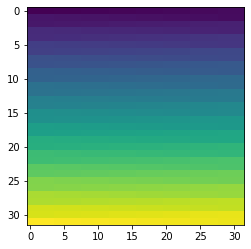

torch.Size([1, 1023, 1, 32, 32])


C:\Users\sprag\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([2, 1023, 1])

In [7]:
tst=torch.ones([2,1,N,N]).to(device)
cnn=BlockedCNN(device,N)
cnn(tst).shape

# Using a 2D RNN

https://github.com/FlorianPfisterer/2D-LSTM-Seq2Seq/blob/master/model/lstm2d_cell.py

THIS IMPLEMENTATION LEAKS GPU MEMORY SOMEWHERE!!!

In [18]:
class LSTM2dCell(nn.Module):
    """
    A 2d-LSTM Cell that computes it's hidden state and cell state based on
        - an input x
        - the previous horizontal hidden and cell state
        - the previous vertical hidden and cell state
    Args:
        input_dim: the input dimension (i.e. second dimension of x)
        state_dim: dimension of the hidden and cell state of this LSTM unit
        device: the device (CPU / GPU) to run all computations on / store tensors on
    """

    def __init__(self, input_dim, state_dim,N, device):
        super(LSTM2dCell, self).__init__()
        self.input_dim = input_dim
        self.state_dim = state_dim
        self.device = device

        # input to state
        self.W_x = nn.Linear(self.input_dim, self.state_dim * 5).to(self.device)
        # previous horizontal hidden state to state
        self.W_hor = nn.Linear(self.state_dim, self.state_dim * 5).to(self.device)
        # previous vertical hidden state to state
        self.W_ver = nn.Linear(self.state_dim, self.state_dim * 5).to(self.device)
        
        self.N=N
        self.lin = nn.Sequential(
                nn.Linear(state_dim,128),
                nn.ReLU(),
                nn.Linear(128,1),
                nn.Sigmoid()
            ).to(device)
        #self.setup(N)
    def forward_pass(self, x, s_prev_hor, s_prev_ver, c_prev_hor, c_prev_ver):
        """
        Forward pass of the 2d-LSTM Cell at horizontal step j and vertical step i (to compute c_ji and s_ji)
        Args:
            x: (batch x input_dim) input at horizontal step j
            s_prev_hor: (batch x state_dim) hidden state of cell at previous horizontal step j-1, same vertical step i
            s_prev_ver: (batch x state_dim) hidden state of cell at previous vertical step i-1, same horizontal step j
            c_prev_hor: (batch x state_dim) cell state of cell at previous horizontal step j-1, same vertical step i
            c_prev_ver: (batch x state_dim) cell state of cell at previous vertical step i-1, same horizontal step j
        Returns:
            c: (batch x state_dim) next cell state (c_ji)
            s: (batch x state_dim) next hidden state (s_ji)
        """
        pre_activation = self.W_x(x) + self.W_hor(s_prev_hor) + self.W_ver(s_prev_ver)
        gates = pre_activation[:, :4*self.state_dim].sigmoid()

        # retrieve input, forget, output and lambda gate from gates
        i = gates[:, 0*self.state_dim:1*self.state_dim]
        f = gates[:, 1*self.state_dim:2*self.state_dim]
        o = gates[:, 2*self.state_dim:3*self.state_dim]
        l = gates[:, 3*self.state_dim:4*self.state_dim]

        c_candidate = pre_activation[:, 4*self.state_dim:].tanh()
        c = f * (l * c_prev_hor + (1 - l) * c_prev_ver) + c_candidate * i
        s = c.tanh() * o

        return c, s
    
    def forward(self,input):
        h0=torch.zeros([input.shape[0],self.state_dim]).to(self.device)
        c0=torch.zeros([input.shape[0],self.state_dim]).to(self.device)
        #set up 2d array to strore the hidden states
        H = [[0 for i in range(self.N)] for i in range(self.N)]
        #set up the 2d array to store the passthrough?
        C = [[0 for i in range(self.N)] for i in range(self.N)]
        out = torch.zeros(input.shape).to(self.device)
        for idx in range(input.shape[1]):
            x = idx//self.N
            y = idx%self.N
            newrow=y
            #make it a snake pattern. . . (massive pain smh)
            if x%2==1:
                y=self.N-y-1
            if x==0:
                hx,cx=h0,c0
            else:
                hx,cx=H[x-1][y],C[x-1][y]
            #need to deal with snake bs now
            if newrow==0:#when there is a new row
                hy,cy=h0,c0
            else:# the direction of the previous horizontal is flipped when x%2==1
                hy,cy=H[x][y-1+2*(x%2)],C[x][y-1+2*(x%2)]
            #I'm storing all the states in 2d arrays
            C[x][y],H[x][y] = self.forward_pass(input[:,idx,:],hx,hy,cx,cy)
            #print(idx,H[x][y])
            out[:,idx,:]=self.lin(H[x][y])
        return out

# Testing presetting the rnn unraveling stuff

In [8]:
    def setup(self,N):
        self.X=np.zeros([N**2],dtype=np.int64)
        self.Y=np.zeros([N**2],dtype=np.int64)
        self.Z=np.zeros([N**2],dtype=np.int64)
        X,Y,Z=self.X,self.Y,self.Z
        for idx in range(N**2-1):
            x = idx//N
            y = idx%N
            newrow=y
            #make it a snake pattern. . . (massive pain smh)
            if x%2==1:
                y=N-y-1
            if x==0:
                X[idx]=N**2-1
            else:
                X[idx]=(x-1)*N+y
            #need to deal with snake bs now
            if newrow==0:#when there is a new row
                Y[idx]=N**2-1
            else:# the direction of the previous horizontal is flipped when x%2==1
                Y[idx]=x*N+y-1+2*(x%2)
            #I'm storing all the states in 2d arrays
            Z[idx]=x*N+y
        self.H=[0 for x in range(N**2)]
        self.C=[0 for x in range(N**2)]
    def forward(self,input):
        H,C=self.H.copy(),self.C.copy()
        h0=torch.zeros([input.shape[0],self.state_dim]).to(self.device)
        c0=torch.zeros([input.shape[0],self.state_dim]).to(self.device)
        X,Y,Z=self.X,self.Y,self.Z
        #set up 2d array to strore the hidden states
        H[N**2-1]=h0
        #set up the 2d array to store the passthrough?
        C[N**2-1]=c0
        out = torch.zeros(input.shape).to(self.device)
        for idx in range(N**2-1):
            hx,cx=H[X[idx]],C[X[idx]]
            hy,cy=H[Y[idx]],C[Y[idx]]
            #I'm storing all the states in 2d arrays
            C[Z[idx]],H[Z[idx]] = self.forward_pass(input[:,idx,:],hx,hy,cx,cy)
            #print(idx,H[x][y])
            out[:,idx,:]=self.lin(H[Z[idx]])
        return out

In [9]:
X=[1,2,3]
Y=X.copy()

# Visualizing RNN Propogation

In [11]:
def testforward():
    h0=-1
    c0=-1
    N=8
    #set up 2d array to strore the hidden states
    H = np.zeros([N,N])-1
    #set up the 2d array to store the passthrough?
    C = np.zeros([N,N])-1
    
    for idx in range(63):
        x = idx//N
        y = idx%N
        newrow=y
        #make it a snake pattern. . . (massive pain smh)
        if x%2==1:
            y=N-y-1
        if x==0:
            hx,cx=h0,c0
        else:
            hx,cx=H[x-1][y],C[x-1][y]
        #need to deal with snake bs now
        if newrow==0:#when there is a new row
            hy,cy=h0,c0
        else:# the direction of the previous horizontal is flipped when x%2==1
            hy,cy=H[x][y-1+2*(x%2)],C[x][y-1+2*(x%2)]
        #I'm storing all the states in 2d arrays
        C[x][y],H[x][y] = cy+1,hx+1
    print(H)
    print(C)

In [12]:
testforward()

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.]
 [ 6.  6.  6.  6.  6.  6.  6.  6.]
 [-1.  7.  7.  7.  7.  7.  7.  7.]]
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 7.  6.  5.  4.  3.  2.  1.  0.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 7.  6.  5.  4.  3.  2.  1.  0.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 7.  6.  5.  4.  3.  2.  1.  0.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.]
 [-1.  6.  5.  4.  3.  2.  1.  0.]]


# Setting Parameters for what model to train

In [13]:
traindata = np.load('data/traindata%d-%d.npy'%(N,B*10000))

In [14]:
traindata = traindata[np.random.permutation(traindata.shape[0])]
traindata.shape

(51200000, 128)

In [15]:
#traindata=traindata[:512000]

# Making sure the shape of everything lines up

In [16]:
batch=torch.zeros([bsize,N*N,1]).to(device)
decompress1D[(bsize,N//2),(1,N//4)](traindata[0:bsize],batch)
if modeltype=='CNN':
    data=torch.zeros([bsize,1,N,N]).to(device)
    decompress2D[(bsize,N//2),(1,N//4)](traindata[0:bsize],data)
else:
    data=batch[:,:-1,:]
label=batch[:,1:,:]
print(data.shape,label.shape)
print(data[:,:,0])

torch.Size([1024, 1023, 1]) torch.Size([1024, 1023, 1])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


In [19]:
#initialize the network
#net=cnn if modeltype=='CNN' else RNN()

typedict={"CNN":cnn,'2d':LSTM2dCell(1,128,N,device),'':RNN()}

net = typedict[modeltype]

print(net(data).shape)
#training parameters
lr = 1e-4 *(bsize/2048)
beta1 = 0.9
beta2=0.999
#Using adam to optimize
optimizer = torch.optim.Adam(
    net.parameters(), 
    lr=lr, 
    betas=(beta1,beta2)
)

torch.Size([1024, 1023, 1])


# Make sure to use a loss which will give you probabilities in your predictions.

I know L2 loss and Binary Cross Entropy Loss will do this

In [28]:
Loss = nn.BCELoss()
losses=[]
validation=[]
vidx= traindata.shape[0]//bsize-1
print(vidx)

49999


# Network actually trains in a few epochs

In [18]:
epoch=1

#set the last batch to validation
#this is a super lazy validation set 

count=0
for i in range(epoch):
    #decided the last batch is validation 
    p = np.random.permutation(traindata.shape[0]//bsize)
    t=time.time()
    for idx in p:
        #decompress the traindata with the gpu
        decompress1D[(bsize,N//2),(1,N//4)](traindata[bsize*idx:bsize*(idx+1)],batch)
        #starting N**2-1 are inputs
        if modeltype=='CNN':
            decompress2D[(bsize,N//2),(1,N//4)](traindata[0:bsize],data)
        else:
            data=batch[:,:-1,:]
        #ending N**2-1 are predictions
        real=batch[:,1:,:]
        
        pred = net(data)
        loss = Loss(pred,real)
        net.zero_grad()
        if idx!=vidx:
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())
        else:
            validation.append(loss.cpu().item())
        count+=1
        if (count%500)==0:
            print("|",end="")
            plt.plot(np.arange(len(losses))/vidx,losses,'.',color=(0,0,1,0.2))
            plt.plot(np.arange(len(validation))+1,validation,'.',color=(1,0,0,0.5))
            plt.yscale("log")
            plt.savefig("Loss.png")
            plt.close()
            torch.save(net,"models/%s%d-%d-%d"%(modeltype,N,B*10000,i))
    if epoch//100==0 or i%(epoch//100)==0:
        print("%.5f, %ds"%(np.mean(losses[-p.size-1:]),time.time()-t),end="| ")
        torch.save(net,"models/%s%d-%d-%d"%(modeltype,N,B*10000,i))

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 12.00 GiB total capacity; 9.83 GiB already allocated; 0 bytes free; 9.83 GiB reserved in total by PyTorch)

In [23]:
print(np.where(p==idx))

(array([49414], dtype=int64),)


In [26]:
torch.save(net,"models/%s%d-%d-%d"%(modeltype,N,B*10000,i))

# Plotting training loss

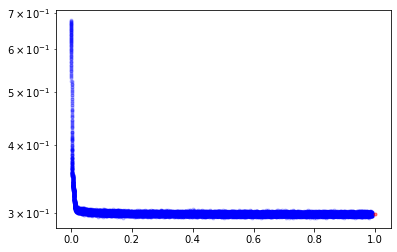

In [25]:
plt.plot(np.arange(len(losses))/vidx,losses,'.',color=(0,0,1,0.2))
plt.plot(np.arange(len(validation))+1,validation,'.',color=(1,0,0,0.5))
plt.yscale("log")
plt.show()
plt.close()

# Testing Our Output

In [23]:
testdata=np.load('data/testdata%d.npy'%N)

In [24]:
testdata.shape
with torch.no_grad():
    print('yay')

yay


# Computing True and Predicted Energies

Note: To go from probability to energy we look at the relation:

$P(s)=\frac{exp(-\beta H(s))}{Z} = \frac{1}{2} \prod_{i=2}^{N^2}p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1) $

So

$ln(P(s)) = -\beta H(s) - ln(Z) = -ln(2)+ \sum_{i=2}^{N^2}ln\big[p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)\big]$

$-\beta H(s) = -ln(2)+ \sum_{i=2}^{N^2}ln\big[p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)\big]+ln(Z)$

$H(s) = \frac{ln(2)- \sum_{i=2}^{N^2}ln\big[p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)\big]}{\beta }-\frac{ln(Z)}{\beta}$

In [25]:
@cuda.jit
def IsingEnergy(grids,E):
    """Compute Energy of 2D ising lattice (J=1 h=0)"""
    z,i,j=cuda.grid(3)
    sz,sx,sy=grids.shape
    s1=grids[z][i][j]*2-1
    s2=grids[z][(i+1)%sx][j]*2-1
    s3=grids[z][i][(j+1)%sy]*2-1
    cuda.atomic.add(E,z,-s1*s2-s1*s3)

def trueEnergies(grids,N):
    """Compute the true energies of a set of data-compressed ising lattices"""
    testbatch=torch.zeros([grids.shape[0],1,N,N]).to(device)
    decompress2D[(grids.shape[0],N//2),(1,N//4)](grids,testbatch)
    testbatch=testbatch.squeeze(1)
    E=np.zeros(grids.shape[0])
    IsingEnergy[(grids.shape[0],N//8,N//8),(1,8,8)](testbatch,E)
    return E

def logprobability(grids,N):
    """compute the logscale probability of a set of data-compressed ising lattices"""
    testbatch=torch.zeros([grids.shape[0],N*N,1]).to(device)
    decompress1D[(grids.shape[0],N//2),(1,N//4)](grids,testbatch)
    if modeltype=='CNN':
        data=torch.zeros([grids.shape[0],1,N,N]).to(device)
        decompress2D[(grids.shape[0],N//2),(1,N//4)](grids,data)
    else:
        data=testbatch[:,:-1,:]
    real=testbatch[:,1:,:]
    #real is going to be a set of actual values
    #and pred is going to be a set of probabilities
    #if real[i]=1 than you muptiply your conditional probability by pred[i]
    #if real[i]=0 than you muliply by 1-pred[i]
    with torch.no_grad():
        pred = net(data)
        ones = real*pred
        zeros=(1-real)*(1-pred)
        total = ones+zeros
    #this is the sum you see in the cell above
    logp=torch.sum(torch.log(total),dim=1).squeeze(1)-np.log(2)
    return logp
    


# Looking at performance on Validation & Test Sets

Note: The validation set has the same distribution of states as the training set
Note: The test set has a very different distribution than our training set: States with energy zero and above will never actually have been seen by our network

In [26]:
def plot_sets(ax0,ax1,c,diff=False,name=''):
    """Creates a plot of predicted vs true energy labels for the rnn
       Since the rnn energy is relative, I set the average rnn ground state energy to the true ground state energy.
       The rest of the energies can then be calculated relative to the ground state.
    """
    # if the bytes are zero then all bits are zero
    ground = np.zeros([2,N*N//8],dtype=np.uint8)
    # if the value of the byte is 255 then all bits are 1
    ground[1]=255
    gprob = logprobability(ground,N)
    gE = trueEnergies(ground,N)
    off=-(gprob.cpu()/B).mean()-gE.mean()
    
    prob = logprobability(traindata[bsize*vidx:bsize*(vidx+1)],N)
    trueE = trueEnergies(traindata[bsize*vidx:bsize*(vidx+1)],N)
    relE=-prob.cpu()/B
    #off=relE.mean()-trueE.mean()
    print(off)
    probB = logprobability(testdata[::max(N**2//8**2-1,1)].copy(),N)
    trueEB = trueEnergies(testdata[::max(N**2//8**2-1,1)].copy(),N)
    relEB=-probB.cpu()/B
    if diff:
        ax0.plot(trueE,relE-off-trueE,'.',color=c+[0.1],label=name)
        ax0.plot(trueE,trueE*0,'k--')
        ax1.plot(trueEB,relEB-off-trueEB,'.',color=c+[0.1],label=name)
        ax1.plot(trueEB,trueEB*0,'k--')
    else:
        ax0.plot(trueE,relE-off,'.',color=c+[0.1],label=name)
        ax0.plot(trueE,trueE,'k--')
        ax1.plot(trueEB,relEB-off,'.',color=c+[0.1],label=name)
        ax1.plot(trueEB,trueEB,'k--')

tensor(2162.2656)


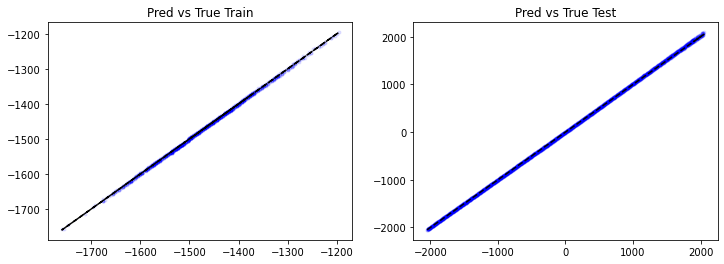

In [29]:
plt.rcParams["figure.figsize"]= [12,4]
fig,(ax0,ax1)=plt.subplots(1,2)
plot_sets(ax0,ax1,[0,0,1])
ax0.set_title("Pred vs True Train")
ax1.set_title("Pred vs True Test")
plt.show()

# Comparing results at different epochs

tensor(2162.2656)


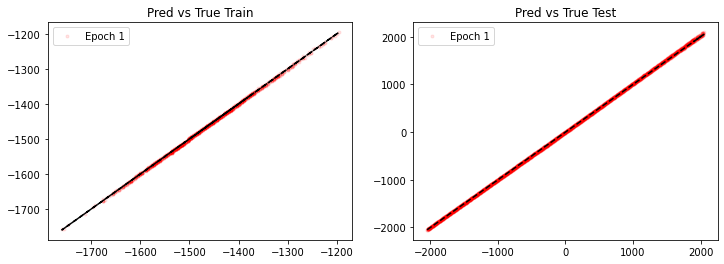

tensor(2162.2656)


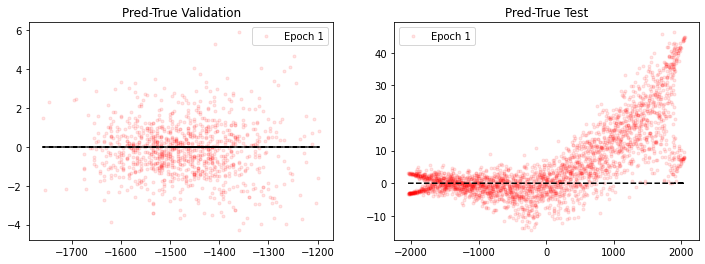

In [30]:
fig,(ax0,ax1)=plt.subplots(1,2)

colors = [[1,0,0],[0,1,0],[0,0,1]]
for i in range(epoch):
    net = torch.load("models/%s%d-%d-%d"%(modeltype,N,B*10000,i))
    plot_sets(ax0,ax1,colors[i],name='Epoch %d'%(i+1))


ax0.set_title("Pred vs True Train")
ax1.set_title("Pred vs True Test")
ax0.legend()
ax1.legend()
plt.show()

fig,(ax0,ax1)=plt.subplots(1,2)

for i in range(epoch):
    net = torch.load("models/%s%d-%d-%d"%(modeltype,N,B*10000,i))
    plot_sets(ax0,ax1,colors[i],True,name='Epoch %d'%(i+1))
ax0.set_title("Pred-True Validation")
ax1.set_title("Pred-True Test")
ax0.legend()
ax1.legend()
plt.show()